# Formula learning

A toy example to learn a formula to predict a synthetic data


Let's say we have a regression problem to predict a target value in $\cal{R}$. 
Input data has $M$ features and a target is computed as 
$$
y_{i} = f(\mathbf x)
$$
we will try various functions $f$ to observe ability to learn it using a DNN.

## A warm-up

Let us predict a simple function : $f(\mathbf x) = 1 + \sum_{i} x_i$

In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline


n_samples = 1000
n_features = 4
b = 1.0
x_max = 10.0
x_min = -10.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [2]:
def f(x):
    return np.sum(x) + 1.0

In [3]:
trainval_y = np.zeros((n_samples, 1))
for i, x in enumerate(trainval_x):
    trainval_y[i, 0] = f(x)

In [4]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

/usr/local/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [5]:
df.head()

,x_0,x_1,x_2,x_3,y
0,-6.914102,-6.726119,-3.977349,-3.884077,-20.501648
1,3.898862,5.879293,-4.758711,3.137195,9.156638
2,-7.225712,9.181021,-1.775547,7.918660,9.098422
3,3.660562,-8.255652,2.180395,-4.587501,-6.002196
4,-7.219169,5.954612,9.647196,2.101526,11.484165


In [6]:
df.loc[0, ['x_%i' % i for i in range(10)]].sum() + 1.0, df.loc[1, ['x_%i' % i for i in range(10)]].sum() + 1.0 

(-20.501647821145582, 9.1566377071599181)

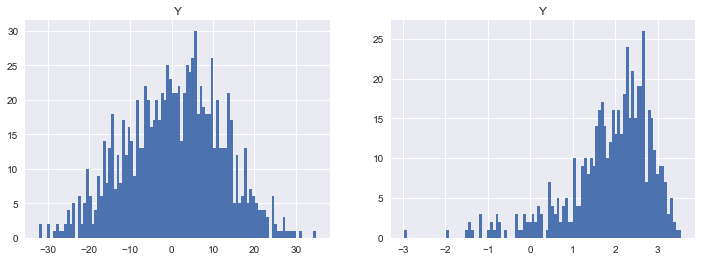

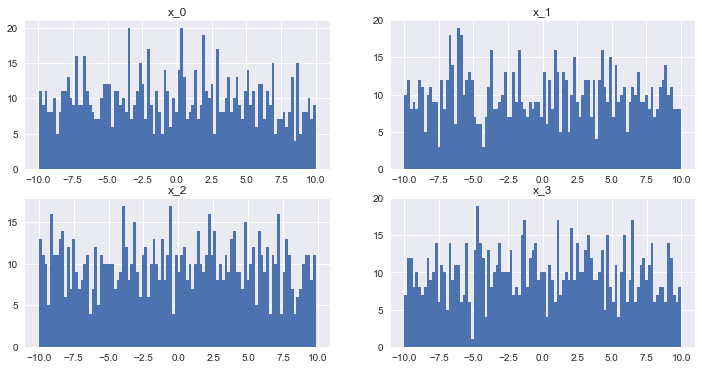

In [7]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.subplot(2, n_features/2, i+1)
    df['x_%i' % i].hist(bins=100)
    plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = b_i + \langle W_i, \mathbf x \rangle,
$$

In [16]:
import tensorflow as tf

In [17]:
def nn(x):    
    b = tf.Variable(tf.random_uniform((1,)))
    W = tf.Variable(tf.random_uniform((x.get_shape().as_list()[1], 1))) 
    return tf.add(b, tf.matmul(x, W))

In [18]:
train_params = {    
    'lr_kwargs': {
        'boundaries': [200, 400, 600],
        'values': [0.1, 0.01, 0.001, 0.0001]
    },
    'lr_f': tf.train.piecewise_constant,        
    'training_epochs': 1000,
    'batch_size': 128,
}

def np_loss(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2.0), axis=-1)

def tf_loss(Y_true, Y_pred):
    return tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1)

def tf_rmse(Y_true, Y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(Y_true - Y_pred), axis=-1))

In [12]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

In [13]:
from keras.backend.tensorflow_backend import _normalize_axis, ndim
import keras.backend as K
from keras.losses import mean_squared_error

Using TensorFlow backend.


In [19]:
Y_true_ = tf.placeholder(tf.float32, shape=(128, 1))
Y_pred_ = tf.placeholder(tf.float32, shape=(128))    
mse = mean_squared_error(Y_true_, Y_pred_)

In [20]:
y_true = np.ones((100, 1))
y_pred = np.linspace(-2, 2, num=100).reshape((100, 1))

mse.eval(feed_dict={Y_true_: y_true, Y_pred_: y_pred})

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

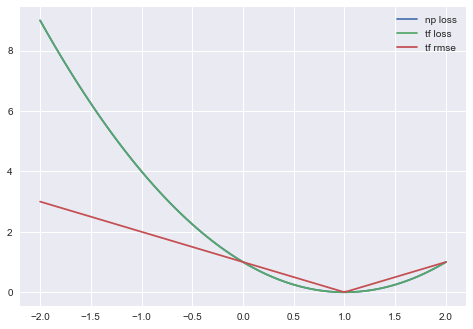

In [32]:
y_true = np.ones((100, 1))
y_pred = np.linspace(-2, 2, num=100).reshape((100, 1))

lss = np_loss(y_true, y_pred)

with tf.Session() as sess:
    lss2, rmse = sess.run([tf_loss(Y_true, Y_pred), tf_rmse(Y_true, Y_pred)], feed_dict={Y_true: y_true, Y_pred: y_pred})


plt.figure()
plt.plot(y_pred, lss, label='np loss')
plt.plot(y_pred, lss2, label='tf loss')
plt.plot(y_pred, rmse, label='tf rmse')
plt.legend()


In [25]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_features))
Y_true = tf.placeholder(tf.float32, shape=(None, 1))

In [26]:
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model    
    Y_pred = nn(X)
    
with tf.name_scope('Loss'):
    # Minimize error using MAE
    loss = tf_loss(Y_true, Y_pred)
    
    
with tf.name_scope('Optimizer'):
    # Gradient Descent
    global_step = tf.Variable(0, trainable=False)    
    lr_f = train_params['lr_f'](global_step, **train_params['lr_kwargs'])    
    optimizer = tf.train.GradientDescentOptimizer(lr_f).minimize(loss)
    
with tf.name_scope('RMSE'):    
    rmse = tf_rmse(Y_true, Y_pred)

# Create a summary to monitor loss tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor RMSE tensor
tf.summary.scalar("RMSE", rmse)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [27]:
Y_true, X, Y_pred

(<tf.Tensor 'Placeholder_1:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'Placeholder:0' shape=(?, 4) dtype=float32>,
 <tf.Tensor 'Model/Add:0' shape=(?, 1) dtype=float32>)

In [28]:
from sklearn.model_selection import train_test_split

display_step = 10

# Launch the graph
print("Start training")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    batch_size = train_params['batch_size']
        
    train_x, val_x, train_y, val_y = train_test_split(trainval_x, trainval_y, train_size=0.75)
    
    n_train_batchs = int(train_x.shape[0]/batch_size)
    n_val_batchs = int(val_x.shape[0]/batch_size)    
    
    # Training cycle
    for epoch in range(train_params['training_epochs']):
        
        if (epoch+1) % display_step == 0:
            print("Epoch: %04d" % (epoch+1))
        
        avg_loss = 0.0
        avg_rmse = 0.0
        # Train over all batches            
        for i in range(n_train_batchs):

            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = train_x[i_start:i_end,:], train_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            _, l, r, summary = sess.run([optimizer, loss, rmse, merged_summary_op],
                                     feed_dict={X: batch_xs, Y_true: batch_ys})
            # Compute average loss
            avg_loss += l / n_train_batchs
            avg_rmse += r / n_train_batchs            
            
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("loss=%.9f, rmse=%.9f" % (avg_loss, avg_rmse))
        
        # Validation
        avg_loss = 0.0
        avg_rmse = 0.0        
        for i in range(n_val_batchs):
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = val_x[i_start:i_end,:], val_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            l, r, summary = sess.run([loss, rmse, merged_summary_op], 
                                     feed_dict={X: batch_xs, Y_true: batch_ys})
            # Compute average loss
            avg_loss += l / n_val_batchs
            avg_rmse += r / n_val_batchs            
            
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("val_loss=%.9f, val_rmse=%.9f" % (avg_loss, avg_rmse))
        
            
        

    print("Optimization Finished!")


Start training


InvalidArgumentError: tags and values not the same shape: [] != [128] (tag 'loss')
	 [[Node: loss = ScalarSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](loss/tags, Loss/Mean/_65)]]

Caused by op 'loss', defined at:
  File "/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/local/Cellar/python3/3.5.2_1/Frameworks/Python.framework/Versions/3.5/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/usr/local/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/usr/local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/usr/local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-91ad9cfc1447>", line 22, in <module>
    tf.summary.scalar("loss", loss)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/summary/summary.py", line 122, in scalar
    tags=scope.rstrip('/'), values=tensor, name=scope)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/ops/gen_logging_ops.py", line 281, in _scalar_summary
    name=name)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/usr/local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): tags and values not the same shape: [] != [128] (tag 'loss')
	 [[Node: loss = ScalarSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](loss/tags, Loss/Mean/_65)]]


## A ratio-like and squared formula

Let $M=10$ and the function to learn is defined as 
$$
f(\mathbf x) = \frac{\sum_i a_i x_i + b} {\sum_i c_i x_i + d} + \alpha \sum_{i,j \neq i} x_i x_j + \beta
$$
where coefficients $a_i$, $b$, $c_i$, $d$, $\alpha$, $\beta$ are randomly chosen.

Setup input data :

In [3]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

n_samples = 10000
n_features = 10
a = np.random.rand(n_features)
b = 1.0
c = np.random.rand(n_features)
d = np.random.rand() * 100.0
alpha = np.random.rand() * 1.0 / 50.0
beta = np.random.rand() * 50.0

x_max = 100.0
x_min = -50.0
trainval_x = (x_max - x_min) * np.random.rand(n_samples, n_features) + x_min

In [4]:
def f(sample_x):
    numerator = np.dot(a, sample_x) + b
    denominator = np.dot(c, sample_x) + d
    t1 = numerator / denominator
    
    t2 = 0
    for v in sample_x:
        t2 += v * (np.sum(sample_x) - v)    
    t2 *= alpha
    return t1 + t2 + beta

In [62]:
trainval_y = np.zeros((n_samples, 1))
for i, x in enumerate(trainval_x):
    trainval_y[i] = f(x)

In [64]:
import pandas as pd
import seaborn as sns

cols_x = ['x_%i' % i for i in range(n_features)]
df = pd.DataFrame(data=trainval_x, columns=cols_x)
df['y'] = trainval_y

In [65]:
df.head()

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y
0,40.425245,87.073970,-37.476818,40.503674,52.398057,65.812719,-34.195931,4.148323,56.190972,-23.843447,60.357144
1,-3.169449,-12.820580,76.330680,-15.900743,-48.068176,87.394782,30.073804,52.666001,58.815798,16.444855,55.289412
2,-20.572207,-3.650812,96.479582,-35.429151,-20.944052,89.106976,-18.394779,-30.838079,79.410738,-42.040173,-21.816756
3,91.229796,-8.355221,74.436617,-22.910272,13.607131,-8.946438,39.777513,85.133333,98.830541,37.519781,181.904713
4,97.344369,71.475973,36.655585,-48.061746,13.271403,23.655426,9.077755,45.041416,-39.383458,78.937506,84.623889


/usr/local/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


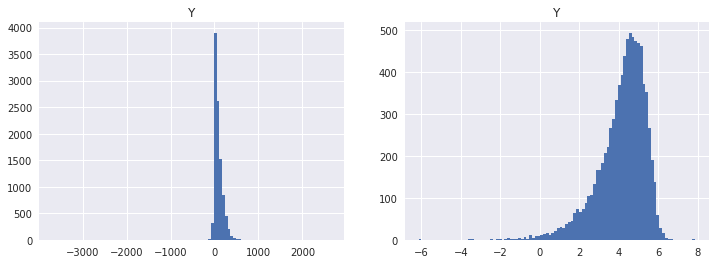

In [52]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
df['y'].hist(bins=100)
plt.title('Y')
plt.subplot(122)
df['y'].apply(np.log).hist(bins=100)
plt.title('Y')

# plt.figure(figsize=(12, 6))
# for i in range(n_features):
#     plt.subplot(2, n_features/2, i+1)
#     df['x_%i' % i].hist(bins=100)
#     plt.title('x_%i' % i)

### Define a NN


Let's define a model as  
$$
f_{nn}(\mathbf x) = \prod_{i=0}^{l-1} \left( b_i + \langle W_i, g(\mathbf x) \rangle \right),
$$
where 
$$
g(\mathbf x) = g_m(\mathbf x) = h^{(1)}_{m,m-1}(\mathbf x) + \frac{1}{\epsilon + h^{(2)}_{m,m-1}(\mathbf x)}
$$
and 
$$
h^{(i)}_{m,m-1}(\mathbf x) = \text{activation}(\langle W_{i,m}, g_{m-1}(\mathbf x) \rangle + b_{i,m}), \\
g_{0} (\mathbf x) = \mathbf x
$$


In [11]:
import pydot
from itertools import chain
def tf_graph_to_dot(in_graph):
    dot = pydot.Dot()
    dot.set('rankdir', 'LR')
    dot.set('concentrate', True)
    dot.set_node_defaults(shape='record')
    all_ops = in_graph.get_operations()
    all_tens_dict = {k: i for i,k in enumerate(set(chain(*[c_op.outputs for c_op in all_ops])))}
    for c_node in all_tens_dict.keys():
        node = pydot.Node(c_node.name)#, label=label)
        dot.add_node(node)
    for c_op in all_ops:
        for c_output in c_op.outputs:
            for c_input in c_op.inputs:
                dot.add_edge(pydot.Edge(c_input.name, c_output.name))
    return dot

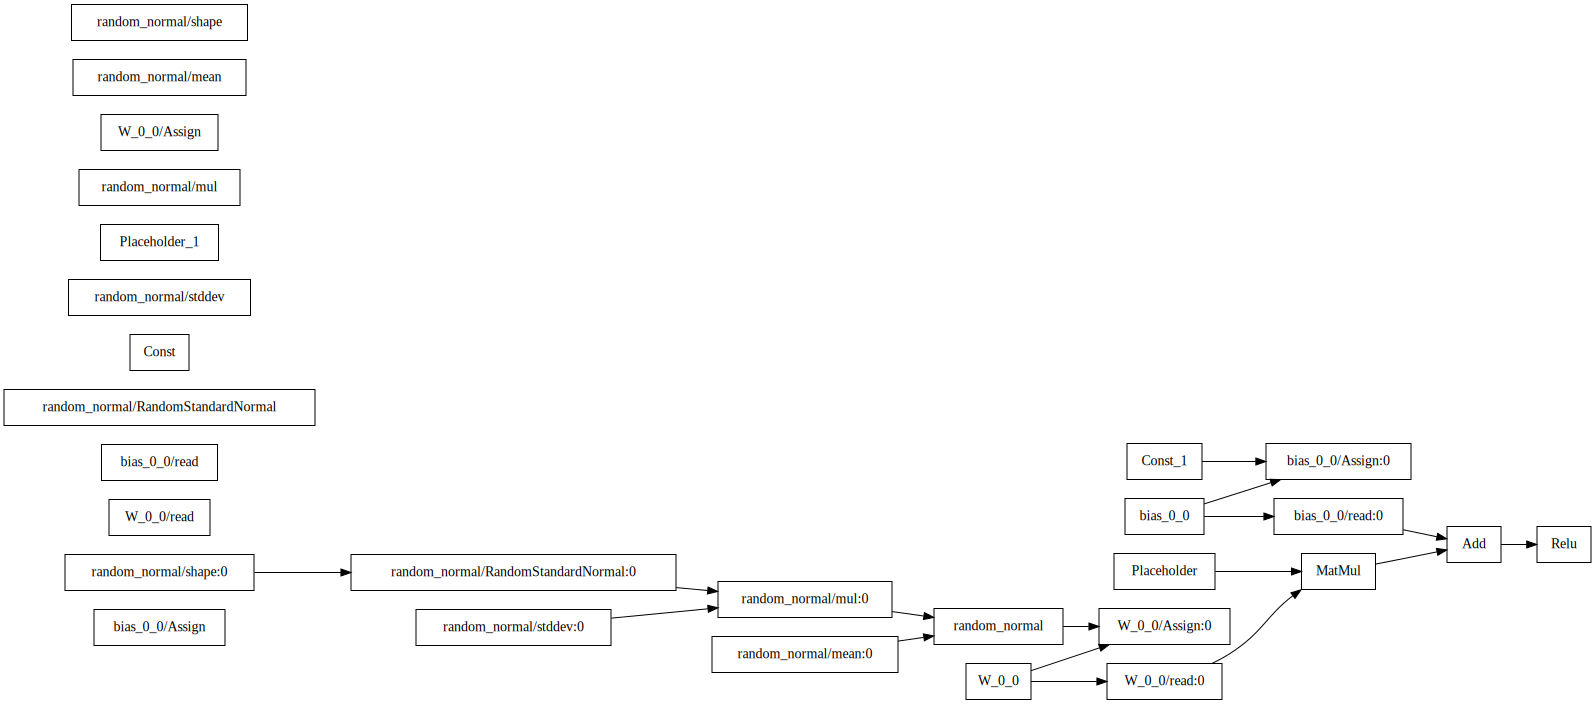

In [15]:
# from IPython.display import SVG
# # Define model
# tf_graph_to_dot(h_0_0.graph).write_svg('simple_tf.svg')
# SVG('simple_tf.svg')

In [9]:
import tensorflow as tf

In [10]:
X = tf.placeholder("float", shape=(None, n_features))
Y = tf.placeholder("float", shape=(None, 1))

In [45]:
epsilon = tf.constant(1e-10)

def h(index, m, x, n_filters, with_activation=True):    
    b = tf.Variable(tf.random_normal([n_filters]), 
                    name='bias_%i_%i' % (index, m))
    W = tf.Variable(tf.random_normal(shape=[x.get_shape().as_list()[1], n_filters],
                                     mean=0.0,
                                     stddev=0.01), 
                    name="W_%i_%i" % (index, m))
    if with_activation:
        return tf.nn.elu(tf.add(tf.matmul(x, W), b))
    else:
        return tf.add(tf.matmul(x, W), b)
        
    
    
def g(m, x, n_filters_list):        
    _x = x if m == 0 else g(m-1, x, n_filters_list)
    inv_h2 = tf.divide(tf.constant(1.0), tf.add(epsilon, h(2, m, _x, n_filters_list[m])))
    return tf.add(h(1, m, _x, n_filters_list[m]), inv_h2)


def nn(x, k, m):    
    nf = 5
    n_filters_list = [nf for j in range(m)]       
    net = h(3, 0, g(m-1, x, n_filters_list), 1)
    for i in range(1, k):
        n_filters_list = [nf for j in range(m)]               
        net = tf.multiply(net, h(3, 0, g(m-1, x, n_filters_list), 1)) 
    return net
    

In [46]:
fnn = nn(X, k=2, m=3)

In [49]:
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    res = sess.run(fnn, feed_dict={X: trainval_x[:10, :]})

In [50]:
res.shape, res

((10, 1), array([[ 0.50211215],
        [ 0.80665046],
        [ 0.58384323],
        [-0.51025158],
        [ 0.32969049],
        [ 0.53186333],
        [ 0.58336145],
        [ 0.58508635],
        [ 0.53465217],
        [ 0.44246921]], dtype=float32))

In [53]:
train_params = {
    'learning_rate': 0.01,
    'training_epochs': 50,
    'batch_size': 128,
}

In [70]:
# Construct model and encapsulating all ops into scopes, making
# Tensorboard's Graph visualization more convenient
with tf.name_scope('Model'):
    # Model
    pred = nn(X, k=2, m=3)
    
with tf.name_scope('Loss'):
    # Minimize error using MAE
    loss = tf.reduce_mean(tf.abs(Y - pred))
    
with tf.name_scope('Optimizer'):
    # Gradient Descent
    optimizer = tf.train.GradientDescentOptimizer(train_params['learning_rate']).minimize(loss)
    
with tf.name_scope('RMSE'):
    # Accuracy    
    rmse = tf.sqrt(tf.reduce_mean(tf.square(Y - pred)))

# Create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# Create a summary to monitor accuracy tensor
tf.summary.scalar("RMSE", rmse)
# Merge all summaries into a single op
merged_summary_op = tf.summary.merge_all()

In [71]:
display_step = 1

# Launch the graph
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    # op to write logs to Tensorboard
    # summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    batch_size = train_params['batch_size']
    # Training cycle
    for epoch in range(train_params['training_epochs']):
        avg_loss = 0.
        
        total_batch = int(trainval_x.shape[0]/batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            i_start = batch_size*i
            i_end = batch_size*(i+1)
            batch_xs, batch_ys = trainval_x[i_start:i_end,:], trainval_y[i_start:i_end, :] 
            # Run optimization op (backprop), loss op (to get loss value)
            # and summary nodes
            _, c, summary = sess.run([optimizer, loss, merged_summary_op],
                                     feed_dict={X: batch_xs, Y: batch_ys})
            # Write logs at every iteration
            # summary_writer.add_summary(summary, epoch * total_batch + i)
            # Compute average loss
            avg_loss += c / total_batch
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print("Epoch: '%04d', loss=%.9f" % (epoch+1, avg_loss))
            print "rmse:", rmse.eval({X: batch_xs, Y: batch_ys})

    print("Optimization Finished!")


Epoch: '0001', loss=91.261261573
Epoch: '0002', loss=89.706600678
Epoch: '0003', loss=89.708581973
Epoch: '0004', loss=89.698378832
Epoch: '0005', loss=89.696581914
Epoch: '0006', loss=89.697173290
Epoch: '0007', loss=89.696890513
Epoch: '0008', loss=89.696553255
Epoch: '0009', loss=89.691995278
Epoch: '0010', loss=89.691468165
Epoch: '0011', loss=89.691360474
Epoch: '0012', loss=89.692095341
Epoch: '0013', loss=89.692089570
Epoch: '0014', loss=89.692068149
Epoch: '0015', loss=89.692063943
Epoch: '0016', loss=89.692004766
Epoch: '0017', loss=89.692061106
Epoch: '0018', loss=89.691756713
Epoch: '0019', loss=89.691749377
Epoch: '0020', loss=89.699559236
Epoch: '0021', loss=89.691815107
Epoch: '0022', loss=89.692143856
Epoch: '0023', loss=89.691685505
Epoch: '0024', loss=89.692127521
Epoch: '0025', loss=89.692656688
Epoch: '0026', loss=89.692272773
Epoch: '0027', loss=89.691308926
Epoch: '0028', loss=89.691579476
Epoch: '0029', loss=89.691655770
Epoch: '0030', loss=89.691710741
Epoch: '00